## 機械学習の単純な例（改２）

N次関数でフィッティングさせてみる。

- 任意の関数で、同じことができるのかを試したかった
- 多次元テンソルになろうが、基本的な処理は同じ


In [1]:
import numpy as np
import torch
from torchviz import make_dot
import matplotlib.pyplot as plt
import japanize_matplotlib

### 入力データ

In [2]:
data = np.array([
    [166.0, 58.7],
    [176.0, 75.7],
    [171.0, 62.1],
    [173.0, 70.4],
    [169.0, 60.1],
])

x = data[:, 0]
y = data[:, 1]


#### データの正規化

In [3]:
X = (x - x.min()) / (x.max() - x.min())
Y = (y - y.min()) / (y.max() - y.min())

### １エポック分の処理

In [4]:
N = 7
X = torch.tensor(X).float()
Y = torch.tensor(Y).float()

W = torch.tensor([1.0 for _ in range(N)], requires_grad=True).float()
B = torch.tensor(1.0, requires_grad=True).float()


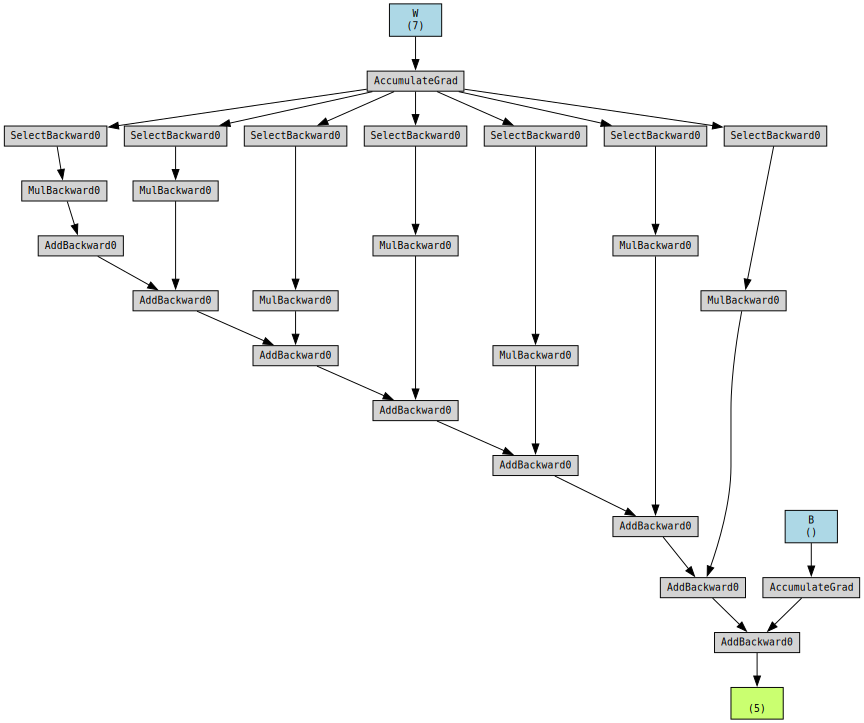

In [5]:
def pred(X, W, B, nn=N):
    return sum([W[ii] * X ** (nn - ii) for ii in range(nn)]) + B

Yp = pred(X, W, B)

params = {'W': W, 'B': B}
g = make_dot(Yp, params=params)

display(g)

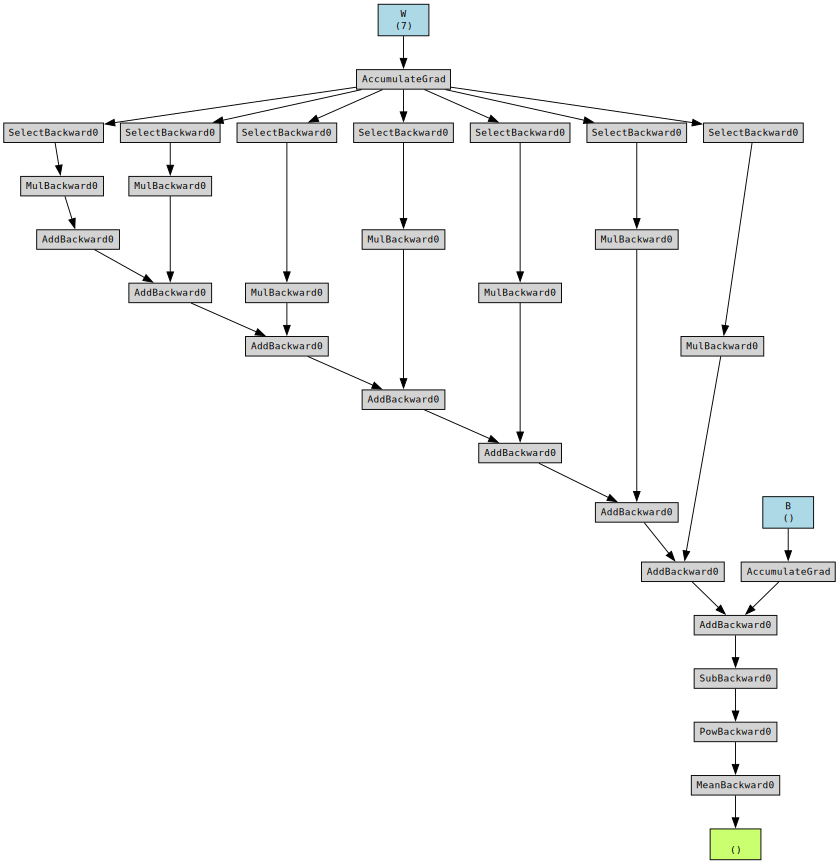

In [6]:
def mse(Yp, Y):
    loss = ((Yp - Y) ** 2).mean()
    return loss

loss = mse(Yp, Y)

g = make_dot(loss, params=params)

display(g)

In [7]:
# これによって勾配を計算する
loss.backward()

In [8]:
lr = 0.001

# 手動で勾配から計算する、いちばん原始的な方法
with torch.no_grad():
    W -= lr * W.grad
    B -= lr * B.grad
    W.grad.zero_()
    B.grad.zero_()


### 複数回、繰り返す

In [9]:
W = torch.tensor([1.0 for _ in range(N)], requires_grad=True).float()
B = torch.tensor(1.0, requires_grad=True).float()

num_epochs = 500
lr = 0.001
history = np.zeros((0, 2))

In [10]:
for epoch in range(num_epochs):
    Yp = pred(X, W, B)
    loss = mse(Yp, Y)
    loss.backward()
    ##### この過程をoptimizerを使って自動化することができる
    with torch.no_grad():
        W -= lr * W.grad
        B -= lr * B.grad
        W.grad.zero_()
        B.grad.zero_()
    #####
    if epoch % 10 == 0:
        item = [epoch, loss.item()]
        history = np.vstack((history, item)) # historyにitemを列方向（axis=0）へ追加してゆく
        if epoch % 100 == 0:
            print(f'epoch: {epoch} / loss: {loss:.4f} / (W, B) = ({W.data.numpy()}, {B.item():.2f})')

print(f'W = {W.data.numpy()}')
print(f'B = {B.data.numpy()}')

print(f'init: loss = {history[0, 1]:.4f}')
print(f'last: loss = {history[-1, 1]:.4f}')

epoch: 0 / loss: 12.2082 / (W, B) = ([0.99711347 0.997073   0.99701136 0.9969153  0.9967593  0.99649155
 0.9959932 ], 0.99)
epoch: 100 / loss: 5.2396 / (W, B) = ([0.7599809  0.7568196  0.7520101  0.7444986  0.7323046  0.71135443
 0.6723459 ], 0.56)
epoch: 200 / loss: 2.2917 / (W, B) = ([0.60033697 0.59543663 0.5879757  0.5763128  0.55735904 0.5247592
 0.46400556], 0.29)
epoch: 300 / loss: 1.0385 / (W, B) = ([0.49142683 0.48567    0.47689617 0.46316272 0.44080952 0.40229896
 0.3304195 ], 0.13)
epoch: 400 / loss: 0.5006 / (W, B) = ([0.41585207 0.40979913 0.40056065 0.38607374 0.36244294 0.32163373
 0.245284  ], 0.03)
W = [0.36274183 0.356743   0.3475696  0.33314985 0.30955997 0.2686867
 0.19196096]
B = -0.02615179680287838
init: loss = 12.2082
last: loss = 0.2815


(0.0, 500.0)

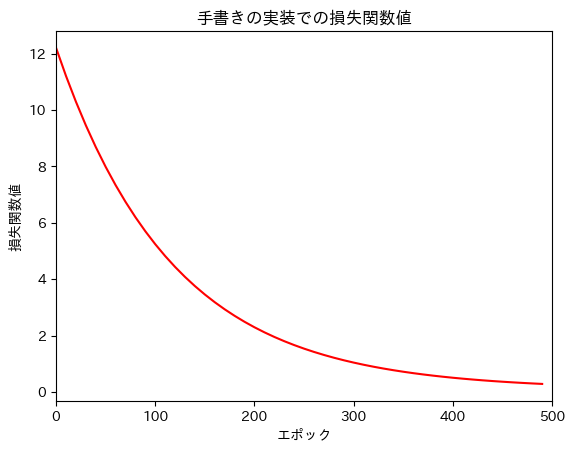

In [11]:
plt.title('手書きの実装での損失関数値')
plt.plot(history[:, 0], history[:, 1], 'r')
plt.xlabel('エポック')
plt.ylabel('損失関数値')
plt.xlim(0, num_epochs)


Text(0, 0.5, '$Y = (y - y_{min}) / (y_{max} - y_{min})$')

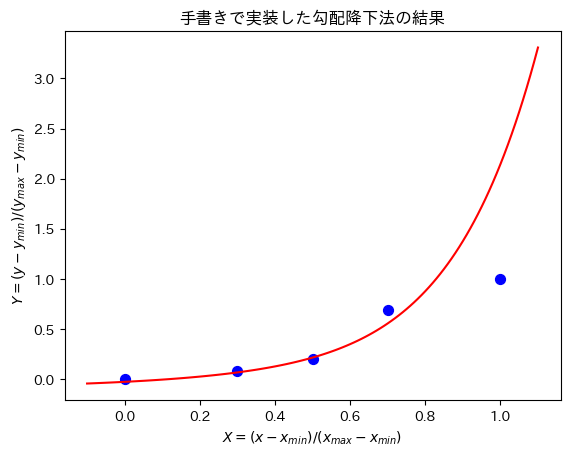

In [12]:
xx = np.arange(X.min() - 0.1, X.max() + 0.1, 0.01)
yy = sum([W[ii].item() * xx ** (N - ii) for ii in range(N)]) + B.item()

plt.title('手書きで実装した勾配降下法の結果')
plt.scatter(X, Y, c='b', s=50)
plt.plot(xx, yy, c='red')
plt.xlabel('$X = (x - x_{min}) / (x_{max} - x_{min})$')
plt.ylabel('$Y = (y - y_{min}) / (y_{max} - y_{min})$')



### パッケージの最適化を利用

In [13]:
W2 = torch.tensor([1.0 for _ in range(N)], requires_grad=True).float()
B2 = torch.tensor(1.0, requires_grad=True).float()

In [14]:
import torch.optim as optim

optimizer = optim.SGD([W2, B2], lr=lr, momentum=0.9)
# https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
history2 = np.zeros((0, 2))

for epoch in range(num_epochs):
    Yp = pred(X, W2, B2)
    loss = mse(Yp, Y)
    loss.backward()
    ##### ここがoptimizerを使った部分
    optimizer.step()
    optimizer.zero_grad()
    #####
    if epoch % 10 == 0:
        item = [epoch, loss.item()]
        history2 = np.vstack((history2, item))
        if epoch % 100 == 0:
            print(f'epoch: {epoch} / loss: {loss:.4f} / (W2, B2) = ({W.data.numpy()}, {B2.item():.2f})')


epoch: 0 / loss: 12.2082 / (W2, B2) = ([0.36274183 0.356743   0.3475696  0.33314985 0.30955997 0.2686867
 0.19196096], 0.99)
epoch: 100 / loss: 0.0567 / (W2, B2) = ([0.36274183 0.356743   0.3475696  0.33314985 0.30955997 0.2686867
 0.19196096], -0.08)
epoch: 200 / loss: 0.0250 / (W2, B2) = ([0.36274183 0.356743   0.3475696  0.33314985 0.30955997 0.2686867
 0.19196096], 0.04)
epoch: 300 / loss: 0.0195 / (W2, B2) = ([0.36274183 0.356743   0.3475696  0.33314985 0.30955997 0.2686867
 0.19196096], 0.07)
epoch: 400 / loss: 0.0173 / (W2, B2) = ([0.36274183 0.356743   0.3475696  0.33314985 0.30955997 0.2686867
 0.19196096], 0.07)


In [15]:
print(f'W2 = {W2.data.numpy()}')
print(f'B2 = {B2.data.numpy()}')

print(f'init: loss = {history2[0, 1]:.4f}')
print(f'last: loss = {history2[-1, 1]:.4f}')

W2 = [0.08004437 0.09249476 0.10963637 0.13267359 0.16214637 0.19558711
 0.22007464]
B2 = 0.0686115249991417
init: loss = 12.2082
last: loss = 0.0159


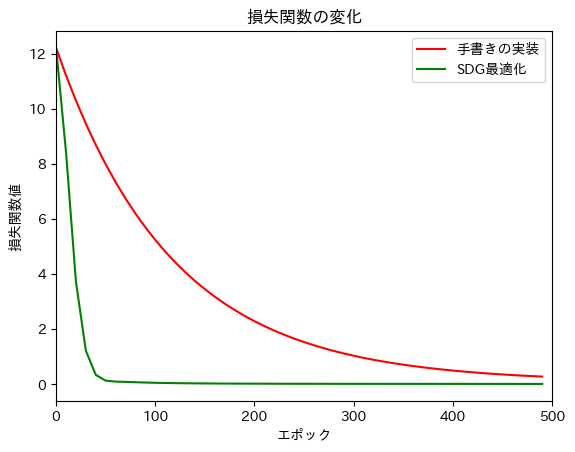

In [16]:
plt.title('損失関数の変化')
plt.xlabel('エポック')
plt.ylabel('損失関数値')
plt.plot(history[:, 0], history[:, 1], 'r', label='手書きの実装')
plt.plot(history2[:, 0], history2[:, 1], 'g', label='SDG最適化')
plt.xlim(0, num_epochs)
plt.legend()

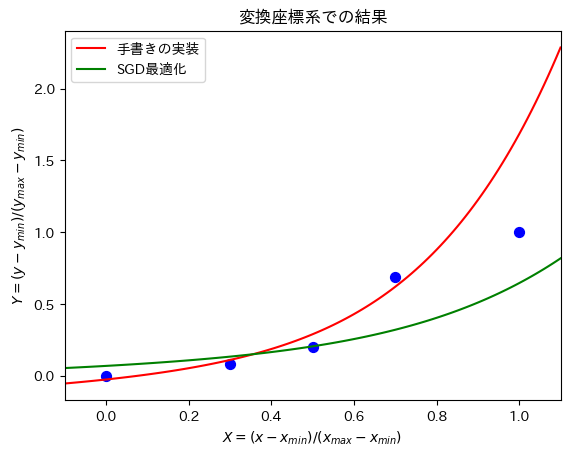

In [17]:
xx = np.arange(X.min() - 0.1, X.max() + 0.1, 0.01)
y1 = sum([W[ii].item() * xx ** (5 - ii) for ii in range(5)]) + B.item()
y2 = sum([W2[ii].item() * xx ** (5 - ii) for ii in range(5)]) + B2.item()


plt.title('変換座標系での結果')
plt.scatter(X, Y, c='blue', s=50)
plt.plot(xx, y1, c='red', label='手書きの実装')
plt.plot(xx, y2, c='green', label='SGD最適化')
plt.xlim(xx.min(), xx.max())
plt.xlabel('$X = (x - x_{min}) / (x_{max} - x_{min})$')
plt.ylabel('$Y = (y - y_{min}) / (y_{max} - y_{min})$')
plt.legend()


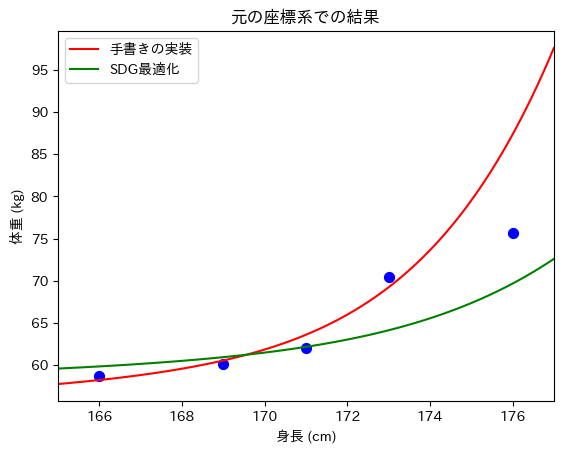

In [18]:
xx = xx * (x.max() - x.min()) + x.min()
y1 = y1 * (y.max() - y.min()) + y.min()
y2 = y2 * (y.max() - y.min()) + y.min()

plt.title('元の座標系での結果')
plt.scatter(x, y, c='blue', s=50)
plt.plot(xx, y1, c='red', label='手書きの実装')
plt.plot(xx, y2, c='green', label='SDG最適化')
plt.xlim(xx.min(), xx.max())
plt.xlabel('身長 (cm)')
plt.ylabel('体重 (kg)')
plt.legend()
